# Data Analyze
## Daily Happiness & Employee Turnover

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot
from sklearn import preprocessing
import numpy as np
from scipy.stats import linregress
import datetime as dt

In [2]:
churn = pd.read_csv('churn.csv')
commentInteractions = pd.read_csv('commentInteractions.csv')
votes = pd.read_csv('votes.csv')
comments_clean_anonimized = pd.read_csv('comments_clean_anonimized.csv')

/home/osboxes/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3155: DtypeWarning: Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


# 1.1 Last participation date of employees

## The lastParticipationExists.csv file contains information about the date of the last interaction of an employee with the app.

    employee: An integer id that identifies an amployee inside a company. (negative = not in the company anymore)
    companyAlias: A hash id for a given company that uses the app. An employee can be uniquely identified with the tuple (employee,companyAlias).
    numVotes: Total number of happyness votes emited by the user.
    lastParticipationDate: Date of the last interaction of the user with the app.
    stillExists: Boolean that is True if the user is still registered in the app.

In [3]:
# create a unique id to join all datasets together later
churn['uid'] = churn.employee.apply(str) + churn.companyAlias

In [4]:
churn = churn.drop_duplicates()
churn.sample()

,employee,companyAlias,numVotes,lastParticipationDate,stillExists,uid
1466,59,57908a2622881200033b34d7,1,Tue Mar 07 21:30:21 CET 2017,False,5957908a2622881200033b34d7


In [5]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4847 entries, 0 to 4846
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   employee               4847 non-null   int64 
 1   companyAlias           4847 non-null   object
 2   numVotes               4847 non-null   int64 
 3   lastParticipationDate  4847 non-null   object
 4   stillExists            4847 non-null   bool  
 5   uid                    4847 non-null   object
dtypes: bool(1), int64(2), object(3)
memory usage: 231.9+ KB


<AxesSubplot:>

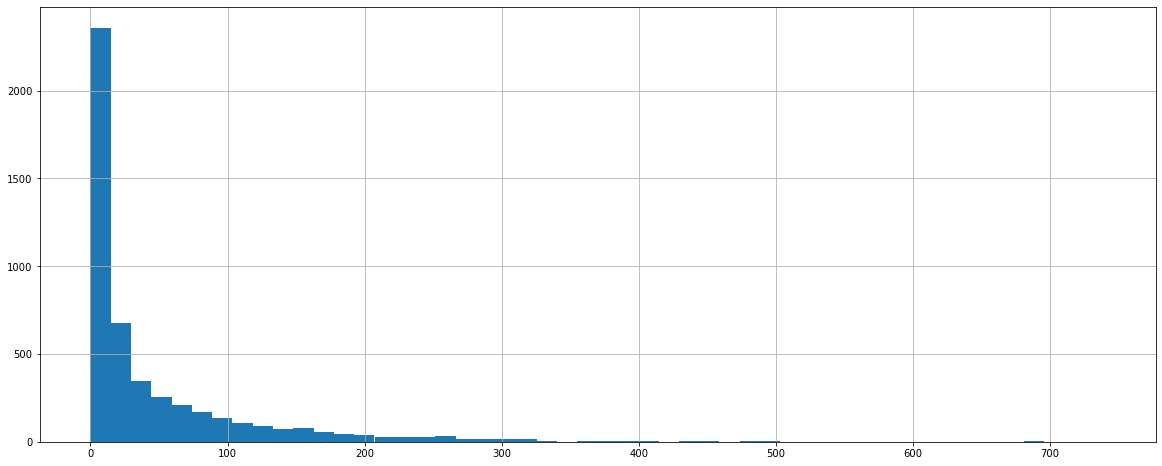

In [6]:
plt.figure(figsize=(20,8)) 
churn.numVotes.hist(bins = 50)

In [7]:
churn.lastParticipationDate = pd.to_datetime(churn.lastParticipationDate)

In [8]:
churn_2016 = churn[(churn['lastParticipationDate'] >= '2016-01-01') & (churn['lastParticipationDate'] < '2017-01-01')]

In [9]:
churn.lastParticipationDate.describe()

<ipython-input-9-4780018c3794>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  churn.lastParticipationDate.describe()


count                          4847
unique                         1844
top       2017-03-20 01:00:00+01:00
freq                            478
first     2014-06-07 02:00:00+02:00
last      2017-03-20 21:25:54+01:00
Name: lastParticipationDate, dtype: object

<AxesSubplot:xlabel='lastParticipationDate', ylabel='numVotes'>

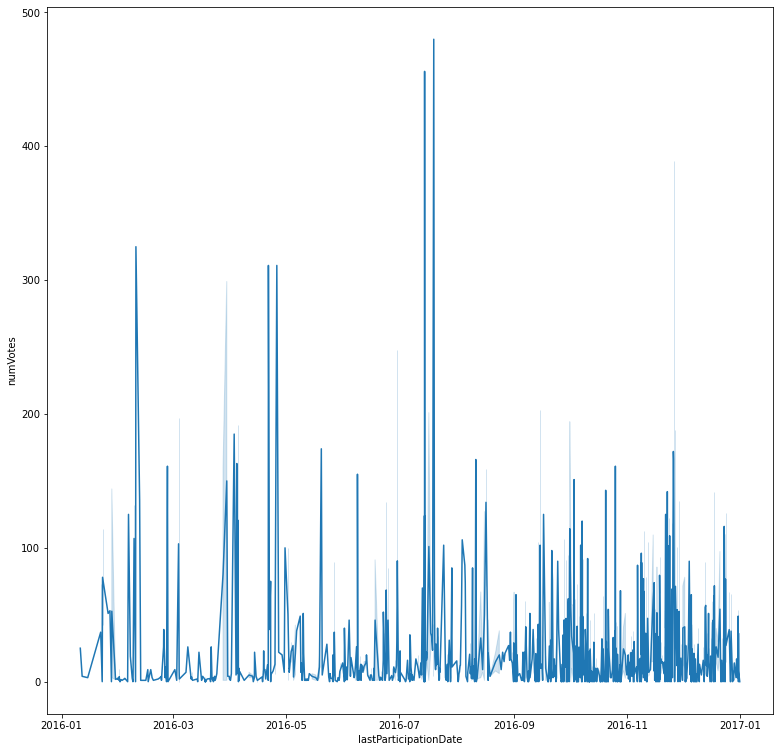

In [10]:
fig, ax = plt.subplots(figsize=(13,13))
sns.lineplot(data=churn_2016, x="lastParticipationDate", y="numVotes")

<AxesSubplot:xlabel='stillExists', ylabel='count'>

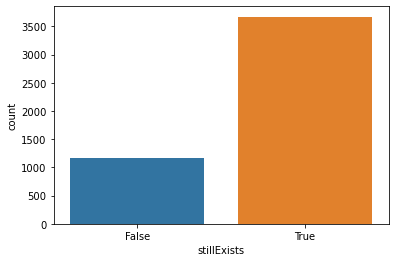

In [11]:
sns.countplot(x="stillExists", data=churn)

In [107]:
churn.stillExists.value_counts()

True     3673
False    1174
Name: stillExists, dtype: int64

# Il y a une majorité de personnes qui sont toujours présentes

In [12]:
to_transform = churn.groupby('companyAlias').mean().drop('employee', axis=1)
to_transform.head()

,numVotes,stillExists
companyAlias,,
5370af43e4b0cff95558c12a,18.857143,0.151786
53a2dd43e4b01cc02f1e9011,31.200000,0.880000
5474b9cde4b0bf7614b2c66f,4.600000,1.000000
54d43612e4b0f6a40755d93e,20.227273,0.636364
54e52607e4b01191dc064966,64.967047,0.376426


In [13]:
x = to_transform[['numVotes']].values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)

In [14]:
#df['stillExists'] = churn.stillExists.astype(int)
df['stillExists'] = to_transform.stillExists.values

In [15]:
df['companyAlias'] = to_transform.reset_index().companyAlias

In [16]:
df.columns = ['numVotes','stillExists','companyAlias']

<AxesSubplot:xlabel='numVotes', ylabel='stillExists'>

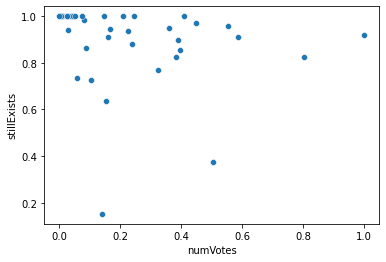

In [17]:
sns.scatterplot(data=df, x="numVotes", y="stillExists")

# Je cherchais à voir si le nombre de votes direct était corrélé à la présence des gens dans une entreprise

In [18]:
personnes_absentes = churn[churn.stillExists == False].uid

In [19]:
churn.describe()

,employee,numVotes
count,4847.000000,4847.000000
mean,167.375490,45.896431
std,208.271041,71.302128
min,-218.000000,0.000000
25%,33.000000,3.000000
50%,113.000000,16.000000
75%,231.000000,59.000000
max,999.000000,740.000000


# 1.2 Employee Interactions

## The file commentInteractions.csv contains information about which employee liked or disliked a given comment.

    employee: An integer id that identifies an amployee inside a company.
    companyAlias: A hash id for a given company that uses the app. An employee can be uniquely identified with the tuple (employee,companyAlias).

    commentId: A unique id for a given comment that allows us to relate it with the comments in anon_comments.csv.

    liked: A boolean that is True if the employee liked the comment.
    disliked: A boolean that is True if the employee disliked the comment.



In [20]:
commentInteractions

,employee,companyAlias,liked,disliked,commentId
0,307,56aec740f1ef260003e307d6,True,False,58d018d7e010990004e38070
1,36,56aec740f1ef260003e307d6,True,False,58d018d7e010990004e38070
2,276,56aec740f1ef260003e307d6,True,False,58d018d7e010990004e38070
3,24,56aec740f1ef260003e307d6,True,False,58d018d7e010990004e38070
4,382,56aec740f1ef260003e307d6,True,False,58d0179ae010990004e3806d
...,...,...,...,...,...
336955,-49,58a728a0e75bda00042a3468,True,False,58ad8adeb8242400048bf834
336956,232,58a728a0e75bda00042a3468,True,False,58ad8adeb8242400048bf834
336957,-25,58a728a0e75bda00042a3468,True,False,58ad8adeb8242400048bf834
336958,36,58a728a0e75bda00042a3468,True,False,58ad8adeb8242400048bf834


In [21]:
commentInteractions[commentInteractions.employee < 0]

,employee,companyAlias,liked,disliked,commentId
8385,-2,56aec740f1ef260003e307d6,True,False,587f674be6b4fd00049bcfef
8420,-2,56aec740f1ef260003e307d6,True,False,587f4557e6b4fd00049bcfce
8492,-2,56aec740f1ef260003e307d6,True,False,587f1897e6b4fd00049bcfae
21444,-4,56aec740f1ef260003e307d6,False,True,5810da7b06f4880003f9f4a7
21699,-6,56aec740f1ef260003e307d6,True,False,580f77bf3443620003f46916
...,...,...,...,...,...
336940,-13,58a728a0e75bda00042a3468,True,False,58ad899db8242400048bf830
336950,-10,58a728a0e75bda00042a3468,True,False,58ad8adeb8242400048bf834
336955,-49,58a728a0e75bda00042a3468,True,False,58ad8adeb8242400048bf834
336957,-25,58a728a0e75bda00042a3468,True,False,58ad8adeb8242400048bf834


In [22]:
commentInteractions['uid'] = commentInteractions.employee.apply(str) + commentInteractions.companyAlias

In [23]:
commentInteractions = commentInteractions.drop_duplicates()

In [24]:
commentInteractions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 336953 entries, 0 to 336959
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   employee      336953 non-null  int64 
 1   companyAlias  336953 non-null  object
 2   liked         336952 non-null  object
 3   disliked      336952 non-null  object
 4   commentId     336952 non-null  object
 5   uid           336953 non-null  object
dtypes: int64(1), object(5)
memory usage: 18.0+ MB


In [25]:
commentInteractions.groupby('uid').sum().drop_duplicates()

,employee
uid,
-1015370af43e4b0cff95558c12a,-101
-1025370af43e4b0cff95558c12a,-102
-1035370af43e4b0cff95558c12a,-618
-10354e52607e4b01191dc064966,-721
-1045370af43e4b0cff95558c12a,-104
...,...
9954e52607e4b01191dc064966,8118
9956aec740f1ef260003e307d6,990
99574c5ade56b6300003009965,3366


In [26]:
commentInteractions = commentInteractions.dropna() #we only have one na row

In [27]:
commentInteractions.liked.sum() / commentInteractions.shape[0]

0.8440133906313065

In [28]:
commentInteractions.disliked.sum() / commentInteractions.shape[0]

0.15598660936869346

In [29]:
commentInteractions.liked = commentInteractions.liked.astype(int)
commentInteractions.disliked = commentInteractions.disliked.astype(int)

In [30]:
commentInteractions_grouped = commentInteractions.groupby('companyAlias').mean().drop('employee', axis = 1).reset_index()

In [31]:
sorted_commentInteractions = commentInteractions_grouped.sort_values(by=['liked'])

<AxesSubplot:xlabel='liked', ylabel='companyAlias'>

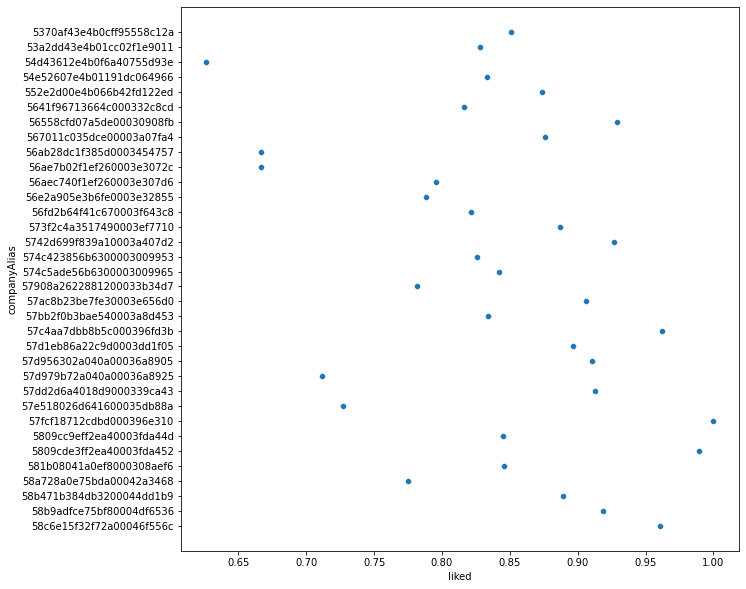

In [32]:
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(data=commentInteractions_grouped, x='liked', y='companyAlias', legend=False)

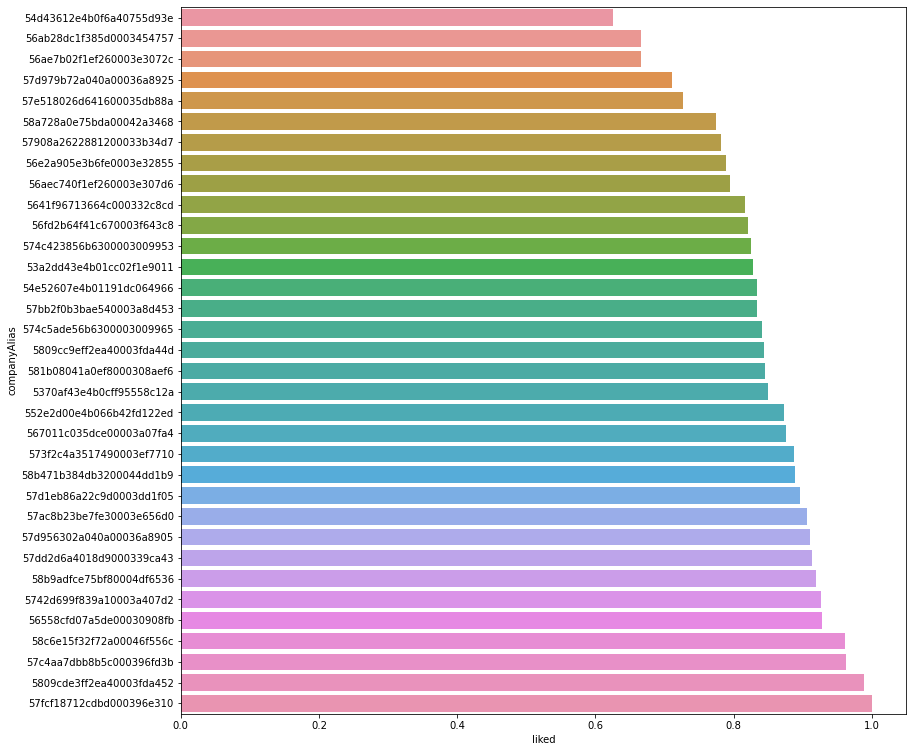

In [33]:
fig, ax = plt.subplots(figsize=(13,13))
ax = sns.barplot(data=sorted_commentInteractions, x='liked', y='companyAlias')

# On peut voir que selon les entreprises l'intéractivité des gens avec les commentaires n'est pas la même : est-ce représentatif de l'ambiance de l'entreprise ?

In [34]:
commentInteractions.describe()

,employee,liked,disliked
count,336952.000000,336952.000000,336952.000000
mean,162.881031,0.844013,0.155987
std,182.071344,0.362843,0.362843
min,-218.000000,0.000000,0.000000
25%,38.000000,1.000000,0.000000
50%,122.000000,1.000000,0.000000
75%,212.000000,1.000000,0.000000
max,999.000000,1.000000,1.000000


In [35]:
commentInteractions.sample()

,employee,companyAlias,liked,disliked,commentId,uid
314815,185,57d956302a040a00036a8905,1,0,581b73b91a0ef8000308af51,18557d956302a040a00036a8905


# 1.3 Happyness votes data

## The data regarding the votes of the app users is stored in votes.csv. This file containg 4 different columns:

    employee: An integer id that identifies an amployee inside a company.
    companyAlias: A hash id for a given company that uses the app. An employee can be uniquely identified with the tuple (employee,companyAlias).
    voteDate: String representing the date a given vote was emited.
    vote: The numeric value of the vote emited ranging from 1 to 4.



In [36]:
votes

,employee,companyAlias,voteDate,vote
0,31,56aec740f1ef260003e307d6,Mon Feb 01 01:00:00 CET 2016,4
1,33,56aec740f1ef260003e307d6,Mon Feb 01 01:00:00 CET 2016,4
2,79,56aec740f1ef260003e307d6,Mon Feb 01 01:00:00 CET 2016,4
3,94,56aec740f1ef260003e307d6,Mon Feb 01 01:00:00 CET 2016,4
4,16,56aec740f1ef260003e307d6,Mon Feb 01 01:00:00 CET 2016,2
...,...,...,...,...
221227,17,573a0671b5ec330003add34a,Fri Jun 03 02:00:00 CEST 2016,3
221228,17,573a0671b5ec330003add34a,Tue Jun 07 02:00:00 CEST 2016,4
221229,17,573a0671b5ec330003add34a,Mon Jun 13 02:00:00 CEST 2016,4
221230,17,573a0671b5ec330003add34a,Tue Jun 28 02:00:00 CEST 2016,4


In [37]:
votes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 221232 entries, 0 to 221231
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   employee      221232 non-null  int64 
 1   companyAlias  221232 non-null  object
 2   voteDate      221232 non-null  object
 3   vote          221232 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 6.8+ MB


In [38]:
votes.voteDate = pd.to_datetime(votes.voteDate)

In [39]:
votes['uid'] = votes.employee.apply(str) + votes.companyAlias
votes = votes.drop_duplicates()

In [40]:
votes.head()

,employee,companyAlias,voteDate,vote,uid
0,31,56aec740f1ef260003e307d6,2016-02-01 01:00:00+01:00,4,3156aec740f1ef260003e307d6
1,33,56aec740f1ef260003e307d6,2016-02-01 01:00:00+01:00,4,3356aec740f1ef260003e307d6
2,79,56aec740f1ef260003e307d6,2016-02-01 01:00:00+01:00,4,7956aec740f1ef260003e307d6
3,94,56aec740f1ef260003e307d6,2016-02-01 01:00:00+01:00,4,9456aec740f1ef260003e307d6
4,16,56aec740f1ef260003e307d6,2016-02-01 01:00:00+01:00,2,1656aec740f1ef260003e307d6


In [41]:
votes.voteDate = votes.voteDate.map(dt.datetime.toordinal)

/home/osboxes/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [42]:
votes_grouped_by_user = votes.groupby('uid').mean().drop('employee', axis = 1)

In [43]:
# permet de calculer l'évolution des votes à travers le temps des votes des utilisateurs
# valeur négative si les votes deviennent moins bon à travers le temps, positive sinon

def calculate_slopes_over_time(df):
    slopes = []
    users = df.uid.unique()
    for user in users:
        y = df[df.uid == user].vote.values
        len_y = len(y)
        x = df[df.uid == user].voteDate.values
        slope, intercept, r_value, p_value, std_err = linregress(x, y)
        slopes.append(slope)
    return slopes

slopes = calculate_slopes_over_time(votes)

/home/osboxes/anaconda3/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/osboxes/anaconda3/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:140: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/osboxes/anaconda3/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


In [44]:
# opposé des résultats car les résultats sont donnés dans une timeline décroissantes
mynegslopes = [ -x for x in slopes]

In [45]:
df_happy = pd.DataFrame(list(zip(mynegslopes, votes.uid.unique())),
               columns =['Happiness', 'uid'])
df_happy = df_happy.fillna(0)

In [46]:
votes_grouped_by_user

,voteDate,vote
uid,,
10053a2dd43e4b01cc02f1e9011,736170.821862,1.004049
10054e52607e4b01191dc064966,735980.514793,2.213018
1005641f96713664c000332c8cd,736187.617647,2.137255
10056aec740f1ef260003e307d6,736292.310160,4.000000
10056e2a905e3b6fe0003e32855,736236.000000,3.750000
...,...,...
995809cc9eff2ea40003fda44d,736383.000000,3.000000
99581b08041a0ef8000308aef6,736338.363636,3.854545
99654e52607e4b01191dc064966,736289.500000,2.450000


In [47]:
votes_grouped_by_user_with_happy = votes_grouped_by_user.merge(df_happy, left_on='uid', right_on='uid')

In [48]:
# group to analyze date with unique employees and not duplicates
votes_grouped = votes.groupby(['employee','companyAlias']).mean()

In [49]:
votes_grouped

voteDate      vote
employee companyAlias                                     
1        5474b9cde4b0bf7614b2c66f  735562.500000  4.000000
         54d43612e4b0f6a40755d93e  735955.562500  3.125000
         54e52607e4b01191dc064966  736009.029851  2.985075
         5641f96713664c000332c8cd  736252.821012  3.171206
         56558cfd07a5de00030908fb  735929.000000  3.500000
...                                          ...       ...
991      54e52607e4b01191dc064966  736228.000000  3.000000
995      54e52607e4b01191dc064966  736337.666667  2.666667
996      54e52607e4b01191dc064966  736289.500000  2.450000
997      54e52607e4b01191dc064966  736282.000000  3.000000
999      54e52607e4b01191dc064966  736291.050000  2.850000

[4377 rows x 2 columns]

In [50]:
votes_by_company = votes_grouped.groupby('companyAlias').mean().reset_index().sort_values(by='vote')

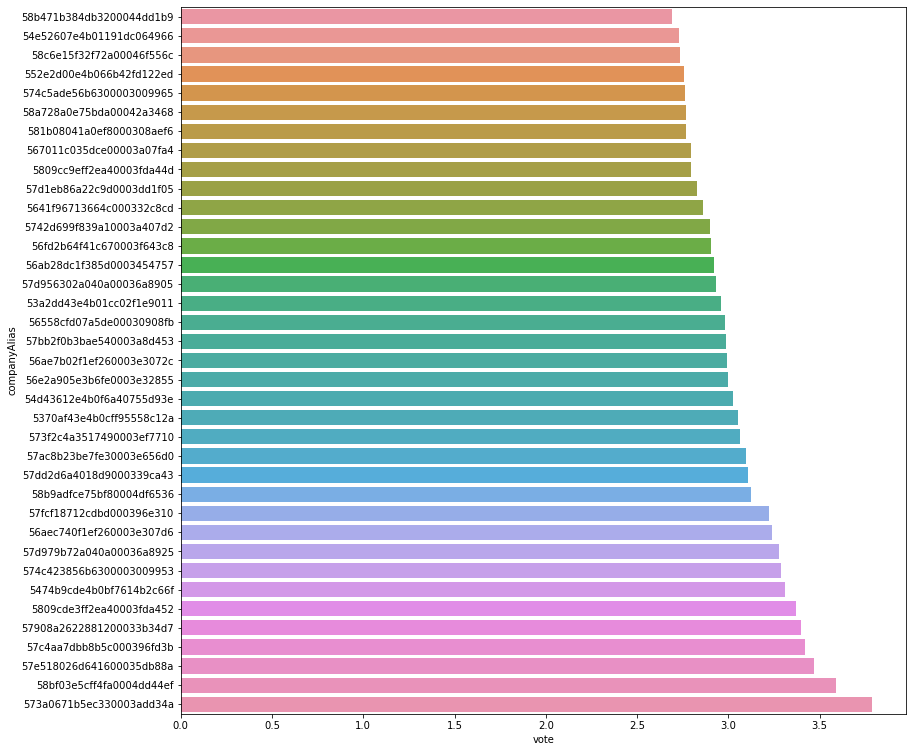

In [51]:
fig, ax = plt.subplots(figsize=(13,13))
ax = sns.barplot(data=votes_by_company, y='companyAlias', x='vote')

# On peut remarquer que selon les entreprises, le bonheur moyen des utilisateurs est bien différent 

In [52]:
merged_company_data = votes_by_company.merge(sorted_commentInteractions)[['companyAlias','liked','vote']]

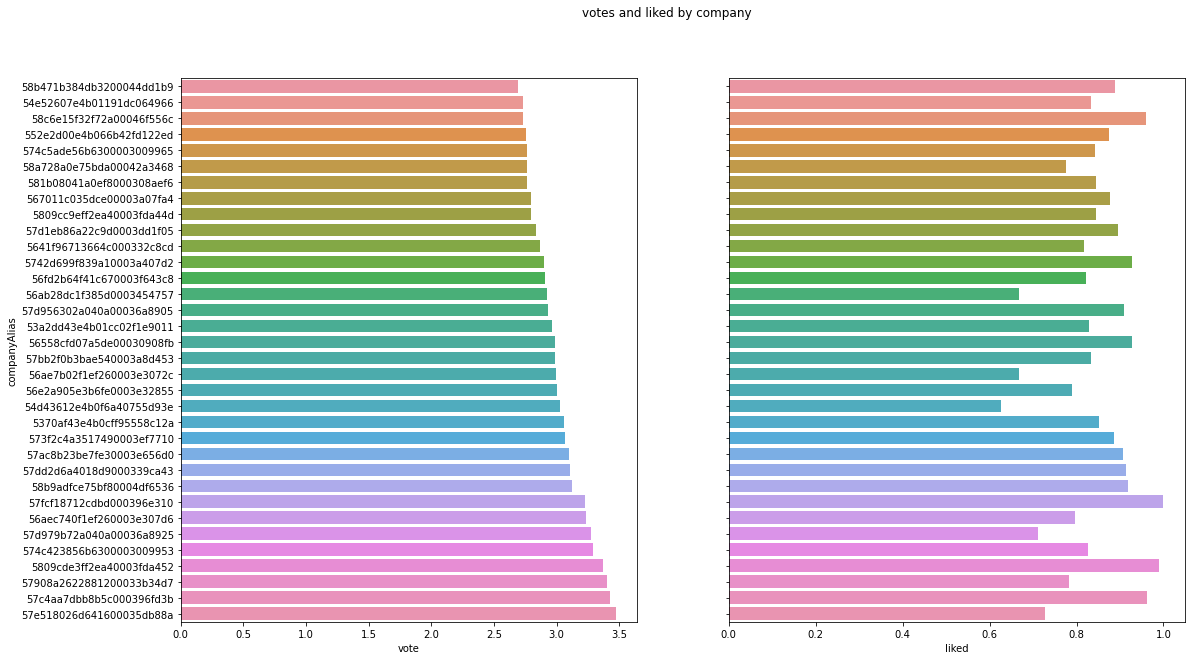

In [53]:
fig, axes = plt.subplots(1, 2, figsize=(18, 10))

fig.suptitle('votes and liked by company')

sns.barplot(ax=axes[0], data=merged_company_data, x='vote', y='companyAlias')
g2 = sns.barplot(ax=axes[1], data=merged_company_data, x='liked', y='companyAlias')
g2.set(ylabel=None)
g2.set(yticklabels=[])
plt.show()

## Je cherchais à voir un lien entre la satisfaction des gens et si les utilisateurs likaient les commentaires, ça n'a pas l'air d'être le cas

# 1.4 Comments data

## It is possible to find data about the comments written in the app in the anon_comments.csv file, and it has the following structure:

    employee: An integer id that identifies an amployee inside a company.
    companyAlias: A hash id for a given company that uses the app. An employee can be uniquely identified with the tuple (employee,companyAlias).
    commentDate: String representing the date a given comment was written.
    commentId: A unique id for a given comment.
    comment: Anonimized comment. It has the same length as the original comment.
    likes: Number of likes that the comment received.
    dislikes: Number of dislikes that the comment received.



In [54]:
comments_clean_anonimized

,employee,companyAlias,commentId,txt,likes,dislikes,commentDate
0,307,56aec740f1ef260003e307d6,58d018d7e010990004e38070,**********************************************...,4.0,0.0,Mon Mar 20 19:00:17 CET 2017
1,382,56aec740f1ef260003e307d6,58d0179ae010990004e3806d,*****************************,1.0,2.0,Mon Mar 20 18:55:16 CET 2017
2,172,56aec740f1ef260003e307d6,58cff8cde010990004e37f6a,***************************,3.0,0.0,Mon Mar 20 16:44:02 CET 2017
3,135,56aec740f1ef260003e307d6,58cfefeee010990004e37f60,***************************,1.0,1.0,Mon Mar 20 16:06:08 CET 2017
4,225,56aec740f1ef260003e307d6,58cfd9b4e010990004e37f52,*********************************,3.0,2.0,Mon Mar 20 14:30:50 CET 2017
...,...,...,...,...,...,...,...
82751,118,58a728a0e75bda00042a3468,58ae85a69fd38f00045eeee4,**********************************************...,1.0,0.0,Thu Feb 23 07:44:48 CET 2017
82752,-10,58a728a0e75bda00042a3468,58ae7fa19fd38f00045eeee2,*****************,2.0,0.0,Thu Feb 23 07:22:12 CET 2017
82753,-8,58a728a0e75bda00042a3468,58adbfcbb8242400048bf8c1,**********************,5.0,0.0,Wed Feb 22 17:43:39 CET 2017
82754,64,58a728a0e75bda00042a3468,58adba78b8242400048bf8b5,**********************************,3.0,0.0,Wed Feb 22 17:20:07 CET 2017


In [55]:
dates = pd.to_datetime(comments_clean_anonimized.commentDate)

<AxesSubplot:>

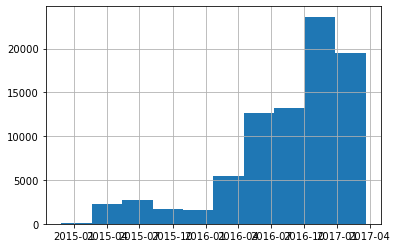

In [56]:
dates.hist()

In [105]:
# Il serait peut être intéressant de limiter les résultats du datasets à partir de 2016 ?

In [57]:
comments_clean_anonimized['uid'] = comments_clean_anonimized.employee.apply(str) + comments_clean_anonimized.companyAlias
comments_clean_anonimized = comments_clean_anonimized.drop_duplicates()

In [106]:
# permet d'obtenir le temps qu'est resté un utilisateur au sein de l'entreprise
def calculate_activity_over_time2(df):
    activities = []
    users = df.uid.unique()
    for user in users:
        activity = df[df.uid == user].commentDate.max() - df[df.uid == user].commentDate.min()
        activities.append(activity)
    return activities

In [59]:
comments_clean_anonimized['txt_len'] = comments_clean_anonimized.txt.str.len()
comments_clean_anonimized.txt_len = comments_clean_anonimized.txt_len.fillna(0)

<ipython-input-59-9136480d8053>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comments_clean_anonimized['txt_len'] = comments_clean_anonimized.txt.str.len()
/home/osboxes/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [60]:
comments_clean_anonimized.commentDate = dates
comments_clean_anonimized.commentDate = comments_clean_anonimized.commentDate.map(dt.datetime.toordinal)

In [61]:
comments_clean_anonimized.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42019 entries, 0 to 82755
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   employee      42019 non-null  int64  
 1   companyAlias  42019 non-null  object 
 2   commentId     42019 non-null  object 
 3   txt           41910 non-null  object 
 4   likes         42018 non-null  float64
 5   dislikes      42018 non-null  float64
 6   commentDate   42019 non-null  int64  
 7   uid           42019 non-null  object 
 8   txt_len       42019 non-null  float64
dtypes: float64(3), int64(2), object(4)
memory usage: 3.2+ MB


In [62]:
comments_clean_anonimized.isna().sum()
# txt with NaN = 0 to len.

employee          0
companyAlias      0
commentId         0
txt             109
likes             1
dislikes          1
commentDate       0
uid               0
txt_len           0
dtype: int64

In [63]:
comments_clean_anonimized.describe()

,employee,likes,dislikes,commentDate,txt_len
count,42019.000000,42018.000000,42018.000000,42019.000000,42019.000000
mean,135.022656,6.889595,1.287234,736180.327899,100.938337
std,162.893510,7.719326,2.740623,3595.588204,198.362784
min,-217.000000,0.000000,0.000000,1.000000,0.000000
25%,28.000000,2.000000,0.000000,736124.000000,27.000000
50%,101.000000,4.000000,0.000000,736244.000000,56.000000
75%,197.000000,9.000000,1.000000,736319.000000,117.000000
max,999.000000,86.000000,53.000000,736408.000000,29057.000000


In [64]:
comments_clean_anonimized[['commentId','uid']]

,commentId,uid
0,58d018d7e010990004e38070,30756aec740f1ef260003e307d6
1,58d0179ae010990004e3806d,38256aec740f1ef260003e307d6
2,58cff8cde010990004e37f6a,17256aec740f1ef260003e307d6
3,58cfefeee010990004e37f60,13556aec740f1ef260003e307d6
4,58cfd9b4e010990004e37f52,22556aec740f1ef260003e307d6
...,...,...
81633,58a7bafb58bf270004ed12fb,558a728a0e75bda00042a3468
81634,58a73c93e75bda00042a3491,1058a728a0e75bda00042a3468
81635,58a7306fe75bda00042a3474,258a728a0e75bda00042a3468
81636,58a73005e75bda00042a3472,158a728a0e75bda00042a3468


In [65]:
activity = calculate_activity_over_time2(comments_clean_anonimized)

In [66]:
# we negate the slopes because the data is from the latest to the oldest
mynegslopes = [ -x for x in activity]

In [67]:
df_activity = pd.DataFrame(list(zip(activity, comments_clean_anonimized.uid.unique())),
               columns =['activity', 'uid'])
#df_activity = df_activity.fillna(0)

In [68]:
df_activity.activity.isna().sum()

0

In [69]:
df_activity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3219 entries, 0 to 3218
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   activity  3219 non-null   int64 
 1   uid       3219 non-null   object
dtypes: int64(1), object(1)
memory usage: 50.4+ KB


In [70]:
votes_grouped_by_user_with_happy = votes_grouped_by_user_with_happy.merge(df_activity, left_on='uid', right_on='uid')

In [71]:
votes_grouped_by_user_with_happy

,uid,voteDate,vote,Happiness,activity
0,10053a2dd43e4b01cc02f1e9011,736170.821862,1.004049,0.000099,189
1,1005641f96713664c000332c8cd,736187.617647,2.137255,0.018121,139
2,10056aec740f1ef260003e307d6,736292.310160,4.000000,-0.000000,227
3,1005742d699f839a10003a407d2,736176.088889,2.877778,0.002205,90
4,100574c423856b6300003009953,736301.487179,3.602564,0.001335,168
...,...,...,...,...,...
2876,9957bb2f0b3bae540003a8d453,736310.250000,2.650000,0.004467,160
2877,9957dd2d6a4018d9000339ca43,736226.000000,4.000000,0.000000,0
2878,99581b08041a0ef8000308aef6,736338.363636,3.854545,-0.005784,77
2879,99654e52607e4b01191dc064966,736289.500000,2.450000,-0.008205,100


In [72]:
votes_grouped_by_user_with_happy.isna().sum()

uid          0
voteDate     0
vote         0
Happiness    0
activity     0
dtype: int64

In [73]:
comments_of_churned_people = comments_clean_anonimized[['commentId','uid']][comments_clean_anonimized['uid'].isin(personnes_absentes)]
comments_of_churned_people

,commentId,uid
936,5873418574f9080004b44f2a,23256aec740f1ef260003e307d6
1160,585a4026da8c4a000470c4f4,23256aec740f1ef260003e307d6
1176,5858f02ef830b00004e7a03e,23256aec740f1ef260003e307d6
1370,5847ec0ff77d9e00047003b0,15556aec740f1ef260003e307d6
1371,5847eb09f77d9e00047003af,23256aec740f1ef260003e307d6
...,...,...
81592,58adbfcbb8242400048bf8c1,-858a728a0e75bda00042a3468
81605,58ad8adeb8242400048bf834,-4758a728a0e75bda00042a3468
81609,58ad84dbb8242400048bf82c,-1758a728a0e75bda00042a3468
81613,58ad8428b8242400048bf827,-1458a728a0e75bda00042a3468


In [74]:
commentInteractions[commentInteractions.commentId.isin(comments_of_churned_people)]

,employee,companyAlias,liked,disliked,commentId,uid


In [75]:
people_which_liked_churned_people = commentInteractions[(commentInteractions.commentId.isin(comments_of_churned_people.commentId)) & (commentInteractions.liked == 1)]
people_which_liked_churned_people

,employee,companyAlias,liked,disliked,commentId,uid
9084,24,56aec740f1ef260003e307d6,1,0,5873418574f9080004b44f2a,2456aec740f1ef260003e307d6
9085,491,56aec740f1ef260003e307d6,1,0,5873418574f9080004b44f2a,49156aec740f1ef260003e307d6
10591,139,56aec740f1ef260003e307d6,1,0,5858f02ef830b00004e7a03e,13956aec740f1ef260003e307d6
10592,136,56aec740f1ef260003e307d6,1,0,5858f02ef830b00004e7a03e,13656aec740f1ef260003e307d6
10593,108,56aec740f1ef260003e307d6,1,0,5858f02ef830b00004e7a03e,10856aec740f1ef260003e307d6
...,...,...,...,...,...,...
336954,26,58a728a0e75bda00042a3468,1,0,58ad8adeb8242400048bf834,2658a728a0e75bda00042a3468
336955,-49,58a728a0e75bda00042a3468,1,0,58ad8adeb8242400048bf834,-4958a728a0e75bda00042a3468
336956,232,58a728a0e75bda00042a3468,1,0,58ad8adeb8242400048bf834,23258a728a0e75bda00042a3468
336957,-25,58a728a0e75bda00042a3468,1,0,58ad8adeb8242400048bf834,-2558a728a0e75bda00042a3468


In [76]:
commentInteractions['liked_churned_people'] = np.where(commentInteractions.uid.isin(people_which_liked_churned_people.uid), 1, 0)

In [77]:
commentInteractions

,employee,companyAlias,liked,disliked,commentId,uid,liked_churned_people
0,307,56aec740f1ef260003e307d6,1,0,58d018d7e010990004e38070,30756aec740f1ef260003e307d6,0
1,36,56aec740f1ef260003e307d6,1,0,58d018d7e010990004e38070,3656aec740f1ef260003e307d6,1
2,276,56aec740f1ef260003e307d6,1,0,58d018d7e010990004e38070,27656aec740f1ef260003e307d6,0
3,24,56aec740f1ef260003e307d6,1,0,58d018d7e010990004e38070,2456aec740f1ef260003e307d6,1
4,382,56aec740f1ef260003e307d6,1,0,58d0179ae010990004e3806d,38256aec740f1ef260003e307d6,1
...,...,...,...,...,...,...,...
336954,26,58a728a0e75bda00042a3468,1,0,58ad8adeb8242400048bf834,2658a728a0e75bda00042a3468,1
336955,-49,58a728a0e75bda00042a3468,1,0,58ad8adeb8242400048bf834,-4958a728a0e75bda00042a3468,1
336956,232,58a728a0e75bda00042a3468,1,0,58ad8adeb8242400048bf834,23258a728a0e75bda00042a3468,1
336957,-25,58a728a0e75bda00042a3468,1,0,58ad8adeb8242400048bf834,-2558a728a0e75bda00042a3468,1


In [78]:
commentInteractions[commentInteractions.uid == '1005641f96713664c000332c8cd']

,employee,companyAlias,liked,disliked,commentId,uid,liked_churned_people
186908,100,5641f96713664c000332c8cd,1,0,57f6c357e308980003c285c0,1005641f96713664c000332c8cd,1
186919,100,5641f96713664c000332c8cd,1,0,57f6be1044892f00033aa1ad,1005641f96713664c000332c8cd,1
186991,100,5641f96713664c000332c8cd,1,0,57f673cd44892f00033aa176,1005641f96713664c000332c8cd,1
187011,100,5641f96713664c000332c8cd,0,1,57f6669944892f00033aa16d,1005641f96713664c000332c8cd,1
187030,100,5641f96713664c000332c8cd,1,0,57f61ac944892f00033aa12e,1005641f96713664c000332c8cd,1
...,...,...,...,...,...,...,...
204742,100,5641f96713664c000332c8cd,1,0,57541d0b01dbb2000395d2d8,1005641f96713664c000332c8cd,1
204793,100,5641f96713664c000332c8cd,0,1,5753fade01dbb2000395d2d1,1005641f96713664c000332c8cd,1
204869,100,5641f96713664c000332c8cd,1,0,5752da225cdb520003700bd4,1005641f96713664c000332c8cd,1
206315,100,5641f96713664c000332c8cd,1,0,573f6e723517490003ef772d,1005641f96713664c000332c8cd,1


In [79]:
commentInteractions.groupby('uid').sum()

,employee,liked,disliked,liked_churned_people
uid,,,,
-1015370af43e4b0cff95558c12a,-101,1,0,1
-1025370af43e4b0cff95558c12a,-102,1,0,1
-1035370af43e4b0cff95558c12a,-618,6,0,6
-10354e52607e4b01191dc064966,-721,7,0,0
-1045370af43e4b0cff95558c12a,-104,0,1,0
...,...,...,...,...
9957bb2f0b3bae540003a8d453,5247,33,20,0
9957dd2d6a4018d9000339ca43,99,1,0,0
99581b08041a0ef8000308aef6,6336,31,33,0


In [80]:
total_interaction_by_user = commentInteractions.groupby('uid').sum().drop('employee', axis = 1)
total_interaction_by_user.liked_churned_people = np.where(total_interaction_by_user.liked_churned_people == 0, 0, 1)
total_interaction_by_user

,liked,disliked,liked_churned_people
uid,,,
-1015370af43e4b0cff95558c12a,1,0,1
-1025370af43e4b0cff95558c12a,1,0,1
-1035370af43e4b0cff95558c12a,6,0,1
-10354e52607e4b01191dc064966,7,0,0
-1045370af43e4b0cff95558c12a,0,1,0
...,...,...,...
9957bb2f0b3bae540003a8d453,33,20,0
9957dd2d6a4018d9000339ca43,1,0,0
99581b08041a0ef8000308aef6,31,33,0


In [81]:
comments_grouped = comments_clean_anonimized.groupby('companyAlias').mean().drop('employee', axis = 1).sort_values(by=['likes'], ascending = False)
comments_grouped.head()

,likes,dislikes,commentDate,txt_len
companyAlias,,,,
5742d699f839a10003a407d2,14.362745,1.144880,736238.235294,197.789397
5641f96713664c000332c8cd,12.674958,2.982185,736235.129412,143.140168
574c5ade56b6300003009965,10.133936,1.902629,736221.328677,126.624486
58a728a0e75bda00042a3468,9.786391,2.821705,735760.719449,96.588640
57d956302a040a00036a8905,9.160800,0.902400,736277.447200,105.902400


<AxesSubplot:xlabel='txt_len', ylabel='likes'>

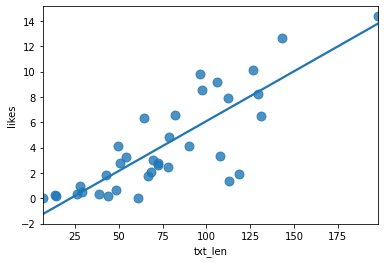

In [82]:
sns.regplot(data=comments_grouped, x="txt_len", y="likes",  scatter_kws={"s": 80}, ci=None, robust=True)

<AxesSubplot:xlabel='txt_len', ylabel='dislikes'>

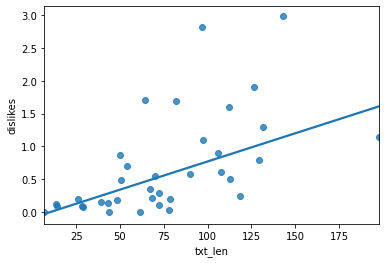

In [83]:
sns.regplot(data=comments_grouped, x="txt_len", y="dislikes", robust= True, ci=None)

## C'est intéressant de voir que lorsque les utilisateurs likent un commentaire, plus celui-ci est long plus il y a de likes. Il en est de même pour les dislikes mais avec une pente bien moins importante

#  Datasets merger : le lien entre tous les datasets se fait ici

In [84]:
churn.sample(2) 

,employee,companyAlias,numVotes,lastParticipationDate,stillExists,uid
1608,-72,54e52607e4b01191dc064966,0,2017-01-18 13:21:43+01:00,False,-7254e52607e4b01191dc064966
4558,171,58a728a0e75bda00042a3468,23,2017-03-20 01:00:00+01:00,True,17158a728a0e75bda00042a3468


In [85]:
churn.numVotes.sum()

222460

In [86]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4847 entries, 0 to 4846
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype                    
---  ------                 --------------  -----                    
 0   employee               4847 non-null   int64                    
 1   companyAlias           4847 non-null   object                   
 2   numVotes               4847 non-null   int64                    
 3   lastParticipationDate  4847 non-null   datetime64[ns, tzlocal()]
 4   stillExists            4847 non-null   bool                     
 5   uid                    4847 non-null   object                   
dtypes: bool(1), datetime64[ns, tzlocal()](1), int64(2), object(2)
memory usage: 391.9+ KB


In [88]:
total_interaction_by_user.head()

,liked,disliked,liked_churned_people
uid,,,
-1015370af43e4b0cff95558c12a,1,0,1
-1025370af43e4b0cff95558c12a,1,0,1
-1035370af43e4b0cff95558c12a,6,0,1
-10354e52607e4b01191dc064966,7,0,0
-1045370af43e4b0cff95558c12a,0,1,0


In [89]:
total_interaction_by_user.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3516 entries, -1015370af43e4b0cff95558c12a to 99954e52607e4b01191dc064966
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   liked                 3516 non-null   int64
 1   disliked              3516 non-null   int64
 2   liked_churned_people  3516 non-null   int64
dtypes: int64(3)
memory usage: 109.9+ KB


In [90]:
votes.sample(2)

,employee,companyAlias,voteDate,vote,uid
197314,202,5742d699f839a10003a407d2,736245,3,2025742d699f839a10003a407d2
212274,120,57d956302a040a00036a8905,736268,3,12057d956302a040a00036a8905


In [91]:
votes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 221145 entries, 0 to 221231
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   employee      221145 non-null  int64 
 1   companyAlias  221145 non-null  object
 2   voteDate      221145 non-null  int64 
 3   vote          221145 non-null  int64 
 4   uid           221145 non-null  object
dtypes: int64(3), object(2)
memory usage: 10.1+ MB


In [92]:
comments_clean_anonimized.sample(2)

,employee,companyAlias,commentId,txt,likes,dislikes,commentDate,uid,txt_len
67991,56,57ac8b23be7fe30003e656d0,58c926a3bd760e00043f16c9,**********************************************...,23.0,1.0,736403,5657ac8b23be7fe30003e656d0,296.0
79233,32,5809cde3ff2ea40003fda452,588f34cfb8d37c0004ece78f,************************************,1.0,0.0,736359,325809cde3ff2ea40003fda452,36.0


In [95]:
comments_clean_anonimized.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42019 entries, 0 to 82755
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   employee      42019 non-null  int64  
 1   companyAlias  42019 non-null  object 
 2   commentId     42019 non-null  object 
 3   txt           41910 non-null  object 
 4   likes         42018 non-null  float64
 5   dislikes      42018 non-null  float64
 6   commentDate   42019 non-null  int64  
 7   uid           42019 non-null  object 
 8   txt_len       42019 non-null  float64
dtypes: float64(3), int64(2), object(4)
memory usage: 3.2+ MB


In [96]:
comments_light = comments_clean_anonimized.drop(['employee','companyAlias','txt', 'commentDate'], axis=1).dropna()
comments_light

,commentId,likes,dislikes,uid,txt_len
0,58d018d7e010990004e38070,4.0,0.0,30756aec740f1ef260003e307d6,62.0
1,58d0179ae010990004e3806d,1.0,2.0,38256aec740f1ef260003e307d6,29.0
2,58cff8cde010990004e37f6a,3.0,0.0,17256aec740f1ef260003e307d6,27.0
3,58cfefeee010990004e37f60,1.0,1.0,13556aec740f1ef260003e307d6,27.0
4,58cfd9b4e010990004e37f52,3.0,2.0,22556aec740f1ef260003e307d6,33.0
...,...,...,...,...,...
81632,58a8a81158bf270004ed1326,7.0,5.0,658a728a0e75bda00042a3468,81.0
81633,58a7bafb58bf270004ed12fb,0.0,0.0,558a728a0e75bda00042a3468,111.0
81634,58a73c93e75bda00042a3491,4.0,0.0,1058a728a0e75bda00042a3468,126.0
81635,58a7306fe75bda00042a3474,1.0,0.0,258a728a0e75bda00042a3468,53.0


In [97]:
comments_light[comments_light.uid == '158a728a0e75bda00042a3468']

,commentId,likes,dislikes,uid,txt_len
80488,58cff0c9e010990004e37f62,5.0,0.0,158a728a0e75bda00042a3468,173.0
80588,58cbe1851da6390004e099c6,2.0,1.0,158a728a0e75bda00042a3468,47.0
80593,58cbe1851da6390004e099c5,1.0,0.0,158a728a0e75bda00042a3468,82.0
80659,58ca639c92db640004f9548a,3.0,1.0,158a728a0e75bda00042a3468,59.0
80820,58c68714dc635b0004321c7d,2.0,0.0,158a728a0e75bda00042a3468,21.0
81095,58bd66cb31608400049b312f,3.0,0.0,158a728a0e75bda00042a3468,78.0
81142,58b97c63e75bf80004df634c,12.0,1.0,158a728a0e75bda00042a3468,173.0
81260,58b70c61917c350004dc0ba7,12.0,0.0,158a728a0e75bda00042a3468,76.0
81480,58b01027e5efa800047675fa,1.0,2.0,158a728a0e75bda00042a3468,109.0
81549,58aec97f9fd38f00045eef47,6.0,1.0,158a728a0e75bda00042a3468,45.0


In [98]:
votes_grouped_by_user_with_happy

,uid,voteDate,vote,Happiness,activity
0,10053a2dd43e4b01cc02f1e9011,736170.821862,1.004049,0.000099,189
1,1005641f96713664c000332c8cd,736187.617647,2.137255,0.018121,139
2,10056aec740f1ef260003e307d6,736292.310160,4.000000,-0.000000,227
3,1005742d699f839a10003a407d2,736176.088889,2.877778,0.002205,90
4,100574c423856b6300003009953,736301.487179,3.602564,0.001335,168
...,...,...,...,...,...
2876,9957bb2f0b3bae540003a8d453,736310.250000,2.650000,0.004467,160
2877,9957dd2d6a4018d9000339ca43,736226.000000,4.000000,0.000000,0
2878,99581b08041a0ef8000308aef6,736338.363636,3.854545,-0.005784,77
2879,99654e52607e4b01191dc064966,736289.500000,2.450000,-0.008205,100


In [99]:
churn.drop(['employee','companyAlias','lastParticipationDate'], axis=1).merge(total_interaction_by_user, left_on='uid', right_on='uid').merge(votes_grouped_by_user_with_happy, left_on='uid', right_on='uid')

,numVotes,stillExists,uid,liked,disliked,liked_churned_people,voteDate,vote,Happiness,activity
0,4,True,51256aec740f1ef260003e307d6,6,0,0,736365.500000,2.500000,-0.000000,29
1,72,True,256aec740f1ef260003e307d6,60,12,1,736168.361111,2.250000,-0.000805,356
2,14,False,48756aec740f1ef260003e307d6,1,0,0,736276.785714,3.142857,0.006202,0
3,14,False,48756aec740f1ef260003e307d6,1,0,0,736276.785714,3.142857,0.006202,0
4,22,True,356aec740f1ef260003e307d6,6,5,0,736120.318182,3.454545,-0.001876,370
...,...,...,...,...,...,...,...,...,...,...
2585,4,True,84958a728a0e75bda00042a3468,11,0,0,736403.250000,2.750000,-0.257143,1
2586,3,True,85058a728a0e75bda00042a3468,8,4,0,736403.666667,3.666667,0.285714,3
2587,5,True,85258a728a0e75bda00042a3468,28,8,0,736405.000000,2.600000,-0.600000,2
2588,1,True,85658a728a0e75bda00042a3468,1,0,0,736405.000000,4.000000,0.000000,0


In [100]:
df = (churn.drop(['employee','companyAlias','lastParticipationDate'], axis=1).merge(total_interaction_by_user, left_on='uid', right_on='uid').
        merge(votes_grouped_by_user_with_happy, left_on='uid', right_on='uid').merge(comments_light.groupby('uid').mean(), left_on='uid', right_on='uid'))

In [101]:
df

,numVotes,stillExists,uid,liked,disliked,liked_churned_people,voteDate,vote,Happiness,activity,likes,dislikes,txt_len
0,4,True,51256aec740f1ef260003e307d6,6,0,0,736365.500000,2.500000,-0.000000,29,7.500000,1.000000,114.500000
1,72,True,256aec740f1ef260003e307d6,60,12,1,736168.361111,2.250000,-0.000805,356,5.428571,4.785714,59.571429
2,14,False,48756aec740f1ef260003e307d6,1,0,0,736276.785714,3.142857,0.006202,0,6.000000,0.000000,92.000000
3,14,False,48756aec740f1ef260003e307d6,1,0,0,736276.785714,3.142857,0.006202,0,6.000000,0.000000,92.000000
4,22,True,356aec740f1ef260003e307d6,6,5,0,736120.318182,3.454545,-0.001876,370,3.333333,0.888889,85.555556
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2585,4,True,84958a728a0e75bda00042a3468,11,0,0,736403.250000,2.750000,-0.257143,1,1.000000,0.500000,56.500000
2586,3,True,85058a728a0e75bda00042a3468,8,4,0,736403.666667,3.666667,0.285714,3,10.333333,0.000000,115.333333
2587,5,True,85258a728a0e75bda00042a3468,28,8,0,736405.000000,2.600000,-0.600000,2,10.666667,5.666667,87.000000
2588,1,True,85658a728a0e75bda00042a3468,1,0,0,736405.000000,4.000000,0.000000,0,15.000000,0.000000,386.000000


In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2590 entries, 0 to 2589
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   numVotes              2590 non-null   int64  
 1   stillExists           2590 non-null   bool   
 2   uid                   2590 non-null   object 
 3   liked                 2590 non-null   int64  
 4   disliked              2590 non-null   int64  
 5   liked_churned_people  2590 non-null   int64  
 6   voteDate              2590 non-null   float64
 7   vote                  2590 non-null   float64
 8   Happiness             2590 non-null   float64
 9   activity              2590 non-null   int64  
 10  likes                 2590 non-null   float64
 11  dislikes              2590 non-null   float64
 12  txt_len               2590 non-null   float64
dtypes: bool(1), float64(6), int64(5), object(1)
memory usage: 265.6+ KB


In [103]:
df.describe()

,numVotes,liked,disliked,liked_churned_people,voteDate,vote,Happiness,activity,likes,dislikes,txt_len
count,2590.000000,2590.000000,2590.000000,2590.000000,2590.000000,2590.000000,2590.000000,2590.000000,2590.000000,2590.000000,2590.000000
mean,70.173359,101.979537,18.910425,0.510425,736246.305450,2.915337,0.002937,408.307336,6.997326,1.239151,93.744155
std,82.805307,203.032179,53.067661,0.499988,123.706463,0.659218,0.075142,14468.153311,5.728580,1.944864,80.592734
min,0.000000,0.000000,0.000000,0.000000,735656.111111,1.000000,-1.000000,0.000000,0.000000,0.000000,0.750000
25%,14.000000,8.000000,1.000000,0.000000,736191.721069,2.555556,-0.001595,13.000000,2.700373,0.111111,43.000000
50%,40.000000,33.000000,4.000000,1.000000,736271.570598,3.000000,0.000243,85.000000,5.428571,0.666667,71.486607
75%,95.000000,103.750000,16.000000,1.000000,736326.163889,3.333333,0.003493,186.750000,9.990000,1.625000,117.285714
max,740.000000,3151.000000,891.000000,1.000000,736405.000000,4.000000,2.000000,736404.000000,46.000000,33.000000,880.500000


# Saving cleaned dataset

In [104]:
df.to_csv('df_to_machine_learning.csv', index=False)